### Chapter 6
# Discrete-time Analysis: Approximation of Continuous Distributions
---
>(c) Tobias Hossfeld  (Aug 2021)<br><br>
> This script and the figures are part of the following book. The book is to be cited whenever the script is used (copyright CC BY-SA 4.0):<br>
> *Tran-Gia, P. & Hossfeld, T. (2021). 
Performance Modeling and Analysis of Communication Networks - A Lecture Note.
Würzburg University Press.*
> *https://doi.org/10.25972/WUP-978-3-95826-153-2*

---


With the time-discrete analysis of GI/GI/1 delay systems, the distribution function of the waiting time can be determined numerically. Any continuous distributions can be approximated by discrete distributions.
Using the example of the M/GI/1 waiting system, the exact waiting time (using Laplace transformation) is compared with the results of the time-discrete analysis. The finer the discretization $ \Delta t $, the more precise the time-discrete analysis. This parameter $ \Delta t $ should be played around in the notebook to see how this affects the accuracy of the numerical results.

The arrival process is a Poisson process with rate $ \lambda = 1 / E[A] $. The service time follows an Erlang-k distribution, $ B \sim E_k(\mu_i) $ with $ E[B] = 1 / \mu $. Each of the $ k $ phases of the Erlang-k distribution follows an exponential distribution with rate $ \mu_i = k \mu = k / E[B] $.

# 1. Continuous M/GI/1 Delay System
## 1.1 Definition of Parameters for Continuous M/GI/1 Delay System
The interarrival time $ A $ and the service time $ B $ are specified. In addition to the parameters of the distributions, the Laplace transform of the service time is also given and implemented as `LT_B (s)`.

In [35]:
from matplotlib import pyplot as plt
import numpy as np
from mpmath import *
import scipy.stats 
from discreteTimeAnalysis import *

##################################
# Interarrival time A ~ Exp(lam)
lam = 0.7   # arrival rate
EA = 1/lam  # mean interarrival time
cA = 1      # coefficient of variation of exponential distribution

# PDF of A
def at(t, lam=lam):
    return lam*np.exp(-lam*t)

# CDF of A
def At(t, lam=lam):
    return 1-np.exp(-lam*t)

##################################
# service time B ~ Erlang_k(lam)
EB = 1     # mean service time 
mu = 1/EB  # service rate
k = 3      # k exponential phases of Erlang-k distribution
cB = 1/np.sqrt(k) # coefficient of variation of the Erlang-k distribution

# Laplace transform of service time B ~ Erlang_k
def LT_B(s, EB=EB, n=k):     
    return 1/(1+s*EB/n)**n # Erlang-k

#  CDF of the service time
def Bt(t, EB=EB, n=k):
    rvB = scipy.stats.erlang(n,scale=EB/n) # we use the scipy implementation
    return rvB.cdf(t)

##################################
# Stability condition: rho<1
rho =lam/mu

# title of plots
title = f'M/M/1 with $\lambda={lam}, E[B]={EB}$' if k==1 else f'M/E$_{k}$/1 with $\lambda={lam}, E[B]={EB}, cB={cB:.2f}$'
print(title)

M/E$_3$/1 with $\lambda=0.7, E[B]=1, cB=0.58$


## 1.2 Laplace Transform of Waiting Time of Continuous M/GI/1
For an M/GI/1 system, the Laplace transform of the waiting time is as follows. The Laplace transform of the service time is required for the calculation: 

$ LT \{b (t) \} = \Phi_B (s) $.

$ \displaystyle LT\{w(t)\} = \Phi_W(s) = \frac{(1-\rho)\cdot s}{s-\lambda+\lambda \Phi_B(s)}$


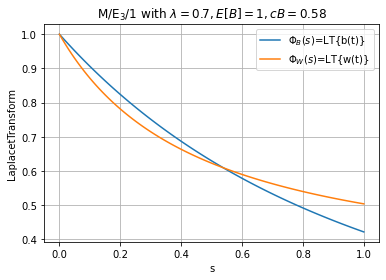

In [36]:
# Laplace transform of waiting time
def LT_W(s, lam=lam, EB=EB):
    rho = EB*lam
    return (1-rho)*s/(s-lam+lam*LT_B(s, EB))

s = np.linspace(0.00001,1,100)
plt.plot(s, LT_B(s), label='$\Phi_B(s)$=LT{b(t)}')
plt.plot(s, LT_W(s), label='$\Phi_W(s)$=LT{w(t)}')
plt.xlabel('s')    
plt.ylabel('LaplacetTransform')
plt.legend()
plt.grid()
plt.title(title);

## 1.3 Numerical waiting time distribution: Inverse numerical Laplace transformation
The inverse numerical Laplace transform delivers the probability density function (PDF) of the waiting time

$LT\{w(t)\} = \Phi_W(s)$.

$w(t) = LT^{-1}\{\Phi_W(s)\}$

To calculate the cumulative distribution function (CDF), the inverse Laplace transform of $ \Phi_W (s) / s $ is calculated.

$ \displaystyle
W(t) = LT^{-1}\{\frac{\Phi_W(s)}{s}\}
$

The `mpmath` package can be used in Python for the inverse Laplace transform purpose. The function is called [invertlaplace](http://mpmath.org/doc/current/calculus/inverselaplace.html).


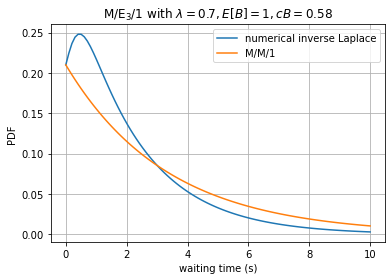

In [37]:
# PDF of the waiting time : w(t) (inverse numerical Laplace transform)
w = lambda t: invertlaplace(LT_W, t ,method='talbot')

# CDF of the waiting time: LT{W(t)} = LT{w(t)}/s
W = lambda t: invertlaplace(lambda s: LT_W(s)/s, t, method='talbot')

# Comparison with an M/M/1 System: PDF of the waiting time
# for k=1 the systems the M/E_k/1 and M/M/1 system are identical.
def wmm1(t, lam=lam, EB=EB):
    mu = 1/EB
    rho = lam/mu
    return mu*(1-rho)*rho*np.exp(-mu*(1-rho)*t)

# Let's plot it
t_lt = np.linspace(1e-9,10,100)
wt = np.array([w(ti) for ti in t_lt])
plt.plot(t_lt, wt, label='numerical inverse Laplace')
plt.plot(t_lt, wmm1(t_lt), label='M/M/1')
plt.xlabel('waiting time (s)')
plt.ylabel('PDF')
plt.legend()
plt.grid()
plt.title(title);

# 2. Discrete-time GI/GI/1 System
## 2.1 Discretization of the Continuous Distributions A and B 
The probability $ P (A \leq t) = A (t) $ is calculated at the discrete places $ i \Delta t $ for $ i = 0,1, ..., a_\max $. Then the discrete distribution $ A_d $ is specified by the probabilities 

$ a_d (i) = P (A_d = i) = A (i \cdot \Delta t) -A ((i-1) \cdot \Delta t) \quad $ for $\; 0 <i <a_\max $.

It is: 

$a_d(0)=0 \\ a_d(a_\max) = 1-A\left((a_\max-1)\cdot \Delta t\right).$

In [50]:
#%% discretization constant
deltaT = 0.5

# compute discretized interarrival times and CDF values
amax = int(t[-1]/deltaT) # define maximum value a_max
tdisc = np.arange(0, amax+1)*deltaT # compute A(t) at the point tdisc
A = At(tdisc)
A[-1] = 1 # insert 1 to compute a(a_max)

# compute probabilities (PMF values)
a = np.insert(np.diff(A), 0, 0) # insert 0 to compute a(0)
xa = np.arange(0, amax+1).astype(int)
EAdisc = np.matmul(a,xa) # mean value

# Generate the corresponding distribution object
Adisc = DiscreteDistribution(xa, a)

print(f'E[A_d]={EAdisc:.2f}={Adisc.mean():.2f}')

E[A_d]=3.39=3.39


### Comparison of continuous and discrete interarrival time 
The CDFs are plotted for the continuous interarrial time $A$ and the discretized interarrival time $A_d$.

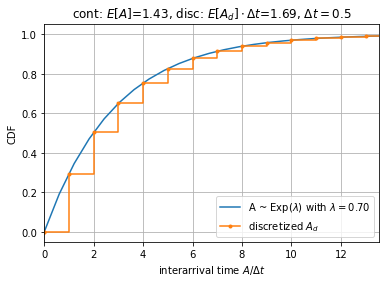

In [52]:
t = np.linspace(0,30,100)
plt.plot(t/deltaT, At(t), label=f'A ~ Exp($\lambda$) with $\lambda={lam:.2f}$')
plt.xlabel('interarrival time $A/\Delta t$')
plt.ylabel('CDF')
plt.grid()
plt.xlim([0,4*EAdisc])
Adisc.plotCDF(label='discretized $A_d$ ')
plt.legend()
plt.title(f'cont: $E[A]$={EA:.2f}, disc: $E[A_d]\cdot \Delta t$={EAdisc*deltaT:.2f}, $\Delta t={deltaT}$');

### Discrete Distribution of interarrival and service time 
Note that the discreted exponential distribution yields a Geometric distribution with parameter $p$:

$ \displaystyle
A_d \sim \mathrm{GEOM}(1-e^{-\lambda \Delta t})$.

$

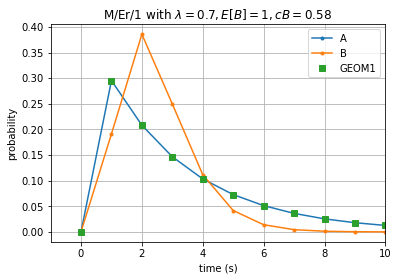

In [5]:
A = DiscreteDistribution(xa, a)

# service time
B = Bt(tdisc, EB=EB) # CDF of cont
B[-1] = 1
b = np.insert(np.diff(B), 0, 0)
B = DiscreteDistribution(np.arange(len(b)), b)

A.plotPMF(label='A')
B.plotPMF(label='B')

D = GEOM(A.mean(), m=1)
D.plotPMF(label='GEOM1', linestyle='', marker='s')

plt.xlabel('time (s)')
plt.ylabel('probability')
plt.legend()
plt.xlim([-1, 10]);
plt.grid(which='major')
plt.title(title);

## Charakteristische Systemfunktion
Die charakteristische Systemfunktion ist die Differenz $C=B-A$. Die Verteilung wird durch Faltung berechnet.
$$ c(k)=b(k)*a(-k)$$

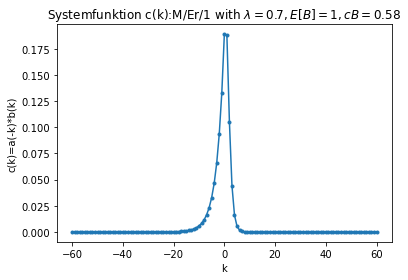

In [6]:
C = B - A

C.plotPMF()
plt.xlabel('k')
plt.ylabel('c(k)=a(-k)*b(k)')
plt.title('Systemfunktion c(k):'+title);

## Zeitdiskrete Analyse des G/G/1 Wartesystems
Zur iterativen Berechnung der Wartezeiten des G/G/1 Wartesystems wird noch der $\pi_0$-Operator benötigt. Die stationären Wartewahrscheinlichkeiten werden mit Hilfe eines Abbruchkriteriums bestimmt. Hier wird dazu die Differenz des Erwartungswertes der Wartezeit in den Iterationsschritten verglichen, bis ein Schwellwert $\epsilon$ unterschritten ist.

Der Erwartungswert der Wartezeit $E[W_{disc}]$ mit der zeitdiskreten Analyse wird verglichen mit dem exakten Wert $E[W]$ (für M/G/1 Wartesysteme). Zusätzlich werden noch die Approximationen von Kingman für den Erwartungswert bzw. eine obere Schranke für den Erwartungswert angegeben.

E[W]=1.5556 (exakt)
E[W_approx]=1.5556, upper bound 2.7698 (Kingman)
E[W_disc]=1.5556 (zeitdiskrete Analyse)


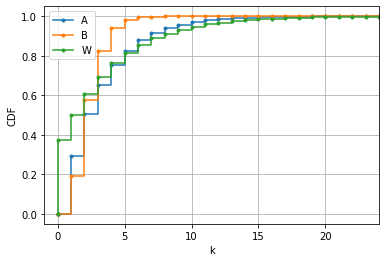

In [7]:
Wn1 = DET(0) # empty system
Wn = DET(1)  # just for initialization

# power method
while Wn != Wn1: # comparison based on means of the distributions
    Wn = Wn1
    Wn1 = max( Wn+C ,0)

W_disc = Wn1

A.plotCDF(label='A')
B.plotCDF(label='B')
W_disc.plotCDF(label='W')
plt.xlabel('k')
plt.ylabel('CDF')
plt.grid(which='major')
plt.xlim([-1, 24])
plt.legend();

EW = EB * rho*(1+cB**2)/(2*(1-rho)) # exact formula for M/GI/1 delay system
#%% Kingman
Kingman = kingman(EA, cA, EB, cB) # Kingman approximation for mean waiting time
Upper = EA*(cA**2+rho**2*cB**2)/2/(1-rho) # upper bound of mean waiting time
print(f'E[W]={EW:.4f} (exakt)')
print(f'E[W_approx]={Kingman:.4f}, upper bound {Upper:.4f} (Kingman)')
print(f'E[W_disc]={EW:.4f} (zeitdiskrete Analyse)')

## Vergleich der Ergebnisse: Zeitdiskrete Analyse vs. M/G/1
Die Verteilungsfunktion der Wartezeit (durch die zeitdiskrete Analyse und Diskretisierung der Verteilungen) wird nun verglichen mit der exakten Lösung (M/G/1 und Laplace Transformation). Zusätzlich wird die Wartezeit des M/M/1 Systems gegenüber gestellt. Für geringere Werte von $\Delta t$ werden die Ergebnisse auf Kosten höheren Berechnungsaufwandes genauer.

NameError: name 'wnx' is not defined

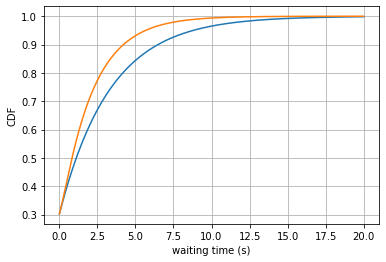

In [8]:
# Exact solution for M/M/1: CDF
def Wmm1(t, lam=lam, EB=EB):
    mu = 1/EB
    rho = lam/mu
    return 1-rho*np.exp(-mu*(1-rho)*t)

t = np.linspace(0.01,20,200)
plt.plot(t, Wmm1(t), label='M/M/1')
Wt = np.array([W(ti) for ti in t])
plt.plot(t, Wt, label='numerical inverse laplace')
plt.xlabel('waiting time (s)')
plt.ylabel('CDF')
plt.grid()
plt.plot(wnx*deltaT,wnp.cumsum(), label='W(k)')    
plt.legend()
plt.xlim([0, 20])     
plt.title(title);